# 配置基础环境

In [25]:
import akshare as ak
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'STKAITI'
plt.rcParams['axes.unicode_minus'] = False
# 关闭警告信息
import warnings
warnings.filterwarnings('ignore')

In [26]:
# 获取上证指数数据
index_code = '000300'
start_date = pd.to_datetime('2016-01-01')
end_date = pd.to_datetime('2024-12-31')
price_df = ak.index_zh_a_hist(symbol=index_code, period='daily', start_date=start_date, end_date=end_date)
price_df
price_df['日期'] = pd.to_datetime(price_df['日期'])
# price_df = price_df[(price_df['日期'] >= start_date) & (price_df['日期'] <= end_date)]
price_df = price_df.sort_values('日期').set_index('日期')

In [27]:
# 计算涨跌幅
price_df['涨跌幅'] = price_df['收盘'].pct_change().fillna(0)
# 计算每日收益率
price_df['returns'] = price_df['收盘'].pct_change().shift(-1).fillna(0)
price_df

,开盘,收盘,最高,最低,成交量,成交额,振幅,涨跌幅,涨跌额,换手率,returns
日期,,,,,,,,,,,
2016-01-04,3725.86,3469.07,3726.24,3468.95,115370674,1.459682e+11,6.90,0.000000,-261.93,0.37,0.002799
2016-01-05,3382.18,3478.78,3518.22,3377.28,162116984,1.960171e+11,4.06,0.002799,9.71,0.52,0.017544
2016-01-06,3482.41,3539.81,3543.74,3468.47,145966144,1.609472e+11,2.16,0.017544,61.03,0.47,-0.069334
2016-01-07,3481.15,3294.38,3481.15,3284.74,44102641,4.713080e+10,5.55,-0.069334,-245.43,0.14,0.020392
2016-01-08,3371.87,3361.56,3418.85,3237.93,185959451,2.034989e+11,5.49,0.020392,67.18,0.60,-0.050307
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-22,3675.65,3684.45,3691.88,3667.09,151914605,2.308394e+11,0.67,0.002255,8.29,0.49,-0.011578
2024-05-23,3672.84,3641.79,3674.37,3633.51,142572990,2.142050e+11,1.11,-0.011578,-42.66,0.46,-0.011069
2024-05-24,3630.83,3601.48,3650.87,3599.67,124791177,1.953447e+11,1.41,-0.011069,-40.31,0.40,0.009504


# 构建牛熊指标

In [28]:
days = 244
# 计算波动率
price_df[f'波动率_{days}'] = price_df['涨跌幅'].rolling(days, min_periods=days//2).std()
# 计算换手率
price_df[f'换手率_{days}'] = price_df['换手率'].rolling(days, min_periods=days//2).mean()
# 计算牛熊指标
price_df[f'牛熊指标'] = price_df[f'波动率_{days}'] / price_df[f'换手率_{days}']

# 可视化

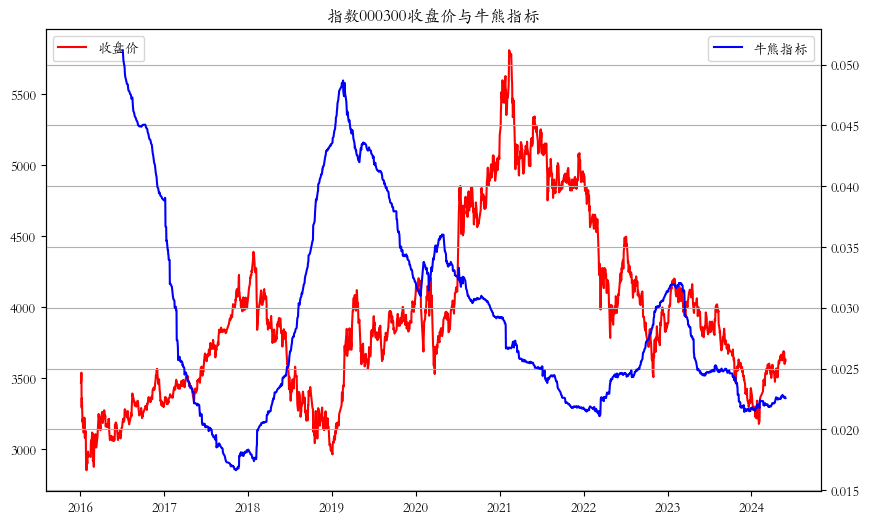

In [29]:
# 可视化指数与牛熊指标的关系
fig, ax1 = plt.subplots(figsize=(10, 6))
# 指数收盘价曲线
ax1.plot(price_df['收盘'], label='收盘价', color='r')
ax1.legend(loc='upper left')
# 牛熊指标曲线
ax2 = ax1.twinx()
ax2.plot(price_df['牛熊指标'], label='牛熊指标', color='b')
ax2.legend(loc='best')

ax1.set_title(f'指数{index_code}收盘价与牛熊指标')
plt.grid()
plt.show()

In [30]:
# 计算牛熊指标和指数收盘价的相关系数
corr = price_df['收盘'].corr(price_df['牛熊指标'])
print(f'指数{index_code}与牛熊指标的相关系数为：', corr)

指数000300与牛熊指标的相关系数为： -0.34651716637459923


# 构建择时策略

In [32]:
# 计算牛熊指标的双均线
days_s = 20
days_l = 60
price_df[f'牛熊指标_ma{days_s}'] = ta.sma(price_df['牛熊指标'], length=days_s)
price_df[f'牛熊指标_ma{days_l}'] = ta.sma(price_df['牛熊指标'], length=days_l)

In [33]:
# 根据牛熊指标的长短均线计算择时信号
timing_df = pd.DataFrame()
timing_df['牛熊指标择时'] = ~(price_df[f'牛熊指标_ma{days_s}'] > price_df[f'牛熊指标_ma{days_l}']) * 1.

In [34]:
# 以指数均线为基准进行对比
price_df[f'指数_ma{days_s}'] = ta.sma(price_df['收盘'], length=days_s)
price_df[f'指数_ma{days_l}'] = ta.sma(price_df['收盘'], length=days_l)
timing_df['指数均线择时'] = (price_df[f'指数_ma{days_s}'] > price_df[f'指数_ma{days_l}']) * 1.
timing_df['不择时'] = 1.

In [35]:
# 计算收益
timing_ret = timing_df.mul(price_df['returns'], axis=0)
cumul_ret = (1 + timing_ret.fillna(0)).cumprod() - 1.

<Axes: xlabel='日期'>

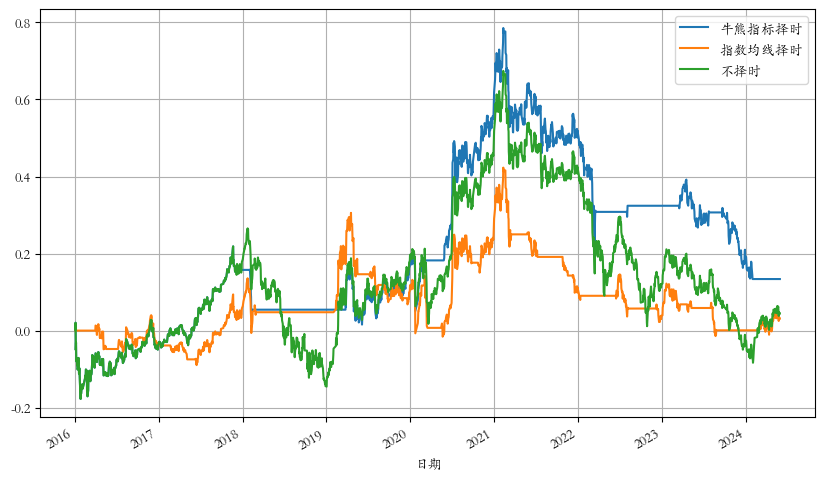

In [38]:
# 可视化效果
cumul_ret.plot(figsize=(10, 6), grid=True)